# This notebook demonstrates one round of Active DA on SVHN->MNIST

In [1]:
import os
import random
import json
import copy
from collections import defaultdict, Counter
from tqdm import tqdm, trange
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import utils
from sample import *
from adapt.models.models import get_model
from data import ASDADataset

torch.manual_seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

### Load source (SVHN) checkpoint

In [2]:
# Load source_ft model
benchmark = 'DIGITS'
cnn = 'LeNet'
num_classes = 10
source, target = 'svhn', 'mnist'
source_path = os.path.join('checkpoints', 'source', '{}_{}_source.pth'.format(source, cnn))
print(source_path)
device = torch.device("cpu")
source_model = get_model(cnn, num_cls=num_classes).to(device)
source_model.load_state_dict(torch.load(source_path, map_location=device), strict=False)

checkpoints/source/svhn_LeNet_source.pth


_IncompatibleKeys(missing_keys=[], unexpected_keys=['pretext_classifier.2.weight', 'pretext_classifier.2.bias'])

In [3]:
args = utils.objectview({'source': source, 'cnn': cnn, 'target': target, \
                         'lr': 2e-4, 'wd': 1e-5, 'adapt_lr': 2e-4, 'adapt_num_epochs': 60, \
                         'src_sup_wt': 0.1, 'unsup_wt': 1.0, 'cent_wt': 0.1, 'batch_size': 128,  \
                         'da_strat': 'mme', 'emb_layer': 'penultimate', 'clue_softmax_t': 1.0})

### Load source (SVHN) dataset

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Using downloaded and verified file: data/train_32x32.mat


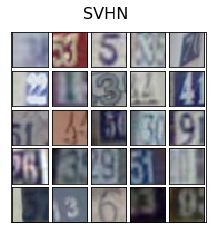

In [4]:
src_dset = ASDADataset(source)
src_train_dset, _, _ = src_dset.get_dsets()
src_train_dset_clean = datasets.SVHN('data', split='train', download=True, transform=transforms.Compose([transforms.ToTensor()]))
_, src_val_loader, src_test_loader, src_train_idx = src_dset.get_loaders(shuffle=False)
src_train_sampler = ActualSequentialSampler(src_train_idx)
src_train_loader = torch.utils.data.DataLoader(src_train_dset, batch_size=128, sampler=src_train_sampler)
utils.representative_examples(src_train_dset_clean, dset_name='SVHN')

### Load target (MNIST) dataset

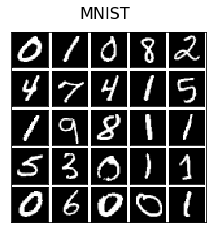

In [5]:
target_dset = ASDADataset(target, valid_ratio=0)
target_train_dset_clean, _, _ = target_dset.get_dsets(normalize=False)
target_train_dset, _, _ = target_dset.get_dsets()
_, _, target_test_loader, train_idx = target_dset.get_loaders(shuffle=False)
train_sampler = ActualSequentialSampler(train_idx)
target_train_loader = torch.utils.data.DataLoader(target_train_dset, batch_size=128, sampler=train_sampler)
train_idx = np.array(train_idx)
utils.representative_examples(target_train_dset_clean, dset_name='MNIST')

### Load source->target checkpoint after unsupervised adaptation

### 1) Unsupervised DA via MME

In [6]:
uda_lr = 2e-04
args.da_strat = 'mme'
adapt_net_file = os.path.join('checkpoints', 'adapt', '{}_{}_{:s}_net_{:s}_{:s}.pth'.format(args.da_strat, uda_lr, cnn, source, target)) 
print(adapt_net_file)
adapt_model = get_model('AdaptNet', num_cls=num_classes, weights_init=adapt_net_file, model=args.cnn)

source_model_adapt = adapt_model.tgt_net.to(device)
discriminator = adapt_model.discriminator.to(device)

checkpoints/adapt/mme_0.0002_LeNet_net_svhn_mnist.pth


### 2) Unsupervised DA via DANN

In [7]:
uda_lr = 2e-04
weight_sharing = 'full'
args.da_strat = 'dann'
adapt_net_file = os.path.join('checkpoints', 'adapt', '{}_{}_{:s}_net_{:s}_{:s}.pth'.format(args.da_strat, uda_lr, cnn, source, target)) 
print(adapt_net_file)
dann_model = get_model('AdaptNet', num_cls=num_classes, weights_init=adapt_net_file, model=args.cnn)

source_model_adapt_dann = dann_model.tgt_net.to(device)
discriminator_dann = dann_model.discriminator.to(device)

checkpoints/adapt/dann_0.0002_LeNet_net_svhn_mnist.pth


### Evaluate checkpoints before and after adaptation

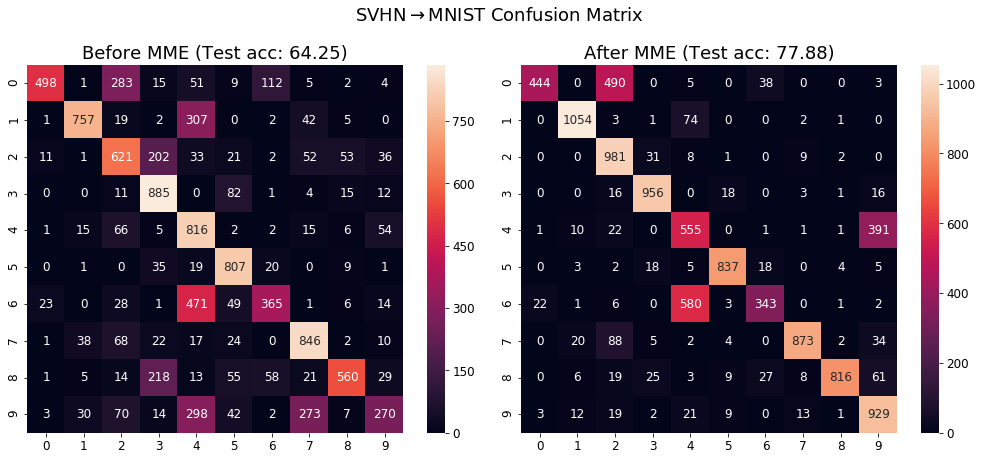

In [8]:
before_acc, cm_before = utils.interactive_test(source_model, device, target_test_loader, split="test")
after_acc, cm_after = utils.interactive_test(source_model_adapt, device, target_test_loader, split="test")

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
utils.plot_cm(axs[0], cm_before, label='Before MME (Test acc: {})'.format(before_acc))
utils.plot_cm(axs[1], cm_after, label='After MME (Test acc: {})'.format(after_acc))

fig.suptitle(r'SVHN$\rightarrow$MNIST Confusion Matrix', fontsize=18)
plt.tight_layout(pad=4.0)
fig.subplots_adjust(hspace=0.27, wspace=0.05)

### Acquire labels via baseline methods and proposed ADA-CLUE strategy

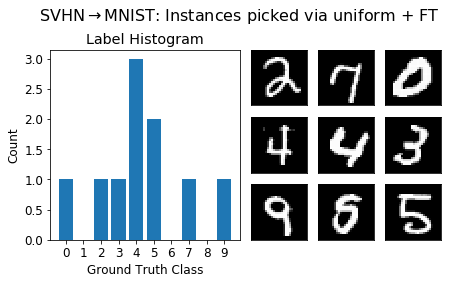

In [29]:
# Uniform + FT
args.al_strat = 'uniform'
args.model_init = 'source'
args.da_strat = 'ft'
uni_ft_strat = get_strategy('uniform', target_train_dset, train_idx, copy.deepcopy(source_model), \
                            discriminator, device, copy.deepcopy(args))
uni_ft_idxs = uni_ft_strat.query(10)
utils.plot_examples(target_train_dset_clean, train_idx[uni_ft_idxs], method='uniform + FT')

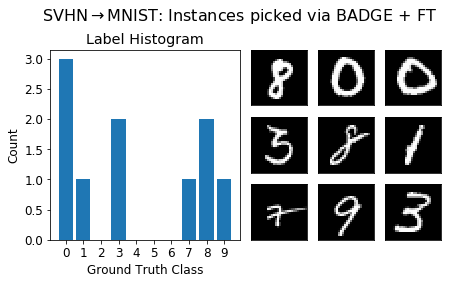

In [28]:
# BADGE + FT
args.al_strat = 'BADGE'
args.model_init = 'source'
args.da_strat = 'ft'
badge_ft_strat = get_strategy('BADGE', target_train_dset, train_idx, copy.deepcopy(source_model), \
                              discriminator, device, copy.deepcopy(args))
badge_ft_idxs = badge_ft_strat.query(10)
utils.plot_examples(target_train_dset_clean, train_idx[badge_ft_idxs], method='BADGE + FT')

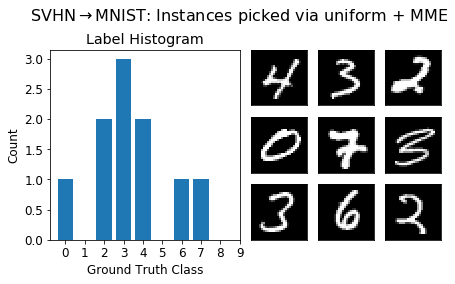

In [24]:
# uniform+MME
args.al_strat = 'uniform'
args.model_init = 'source'
args.da_strat = 'mme'
ssda_mme_strat = get_strategy('uniform', target_train_dset, train_idx, copy.deepcopy(source_model_adapt), \
                              discriminator, device, copy.deepcopy(args))
ssda_mme_idxs = ssda_mme_strat.query(10)
utils.plot_examples(target_train_dset_clean, train_idx[ssda_mme_idxs], method='uniform + MME')

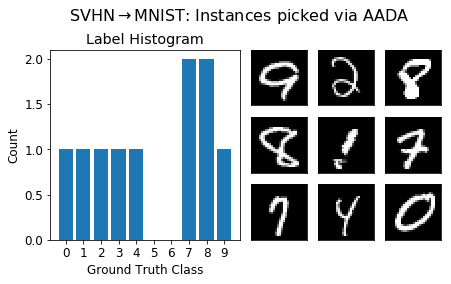

In [12]:
# AADA
args.al_strat = 'AADA'
args.model_init = 'source'
args.da_strat = 'dann'
aada_strat = get_strategy('AADA', target_train_dset, train_idx, copy.deepcopy(source_model_adapt_dann), \
                          discriminator_dann, device, copy.deepcopy(args))
aada_idxs = aada_strat.query(10)
utils.plot_examples(target_train_dset_clean, train_idx[aada_idxs], method='AADA')

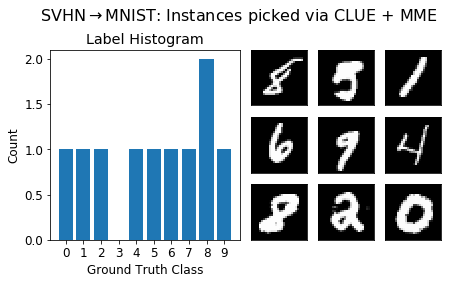

In [30]:
# ADA-CLUE
args.al_strat = 'CLUE'
args.model_init = 'source'
args.da_strat = 'mme'
adaclue_strat = get_strategy('CLUE', target_train_dset, train_idx, copy.deepcopy(source_model_adapt), \
                             discriminator, device, copy.deepcopy(args))
adaclue_idxs = adaclue_strat.query(10)
utils.plot_examples(target_train_dset_clean, train_idx[adaclue_idxs], method='CLUE + MME')

### Update model for each method

In [14]:
target_accs = defaultdict(dict)
def train_model(method, curr_strat, sel_idxs, tgt_dset, tgt_test_loader, src_train_loader):
    start_perf, _ = utils.test(curr_strat.model, device, tgt_test_loader)
    out_str = '{} | Test performance on {}->{}: Round 0 (B=0): {:.2f}'.format(method, source, target, start_perf)

    idxs_lb = np.zeros(len(train_idx), dtype=bool)
    idxs_lb[sel_idxs] = True
    assert curr_strat.idxs_lb.sum() == 0, 'Model already updated'
    curr_strat.update(idxs_lb)    

    best_model = curr_strat.train(tgt_dset, \
                                  da_round=1, \
                                  src_loader=src_train_loader, \
                                  src_model=curr_strat.model)
    test_perf, _ = utils.test(best_model, device, tgt_test_loader)
    out_str += '\t Round 1 (B={}): {:.2f}'.format(10, test_perf)
    print(out_str)
    return start_perf, test_perf

In [15]:
# uniform+FT
uni_r0_perf, uni_perf = train_model('uniform + FT', uni_ft_strat, uni_ft_idxs, target_train_dset, \
                                    target_test_loader, src_train_loader)
target_accs['source_uniform_ft'] = defaultdict(dict)
target_accs['source_uniform_ft']["0.0"] = uni_r0_perf
target_accs['source_uniform_ft']["1.0"] = uni_perf


Evaluating model on test...
[Train target finetuning] Epoch: 0 Target Sup. Loss: 4.042
[Train target finetuning] Epoch: 10 Target Sup. Loss: 1.841
[Train target finetuning] Epoch: 20 Target Sup. Loss: 0.145
[Train target finetuning] Epoch: 30 Target Sup. Loss: 0.320
[Train target finetuning] Epoch: 40 Target Sup. Loss: 0.083
[Train target finetuning] Epoch: 50 Target Sup. Loss: 1.551

Evaluating model on test...
uniform+FT | Test performance on svhn->mnist: Round 0 (B=0): 64.25	 Round 1 (B=10): 72.02


In [16]:
# BADGE+FT
badge_r0_perf, badge_perf = train_model('BADGE + FT', badge_ft_strat, badge_ft_idxs, target_train_dset, \
                                        target_test_loader, src_train_loader)
target_accs['source_BADGE_ft'] = defaultdict(dict)
target_accs['source_BADGE_ft']["0.0"] = badge_r0_perf
target_accs['source_BADGE_ft']["1.0"] = badge_perf


Evaluating model on test...
[Train target finetuning] Epoch: 0 Target Sup. Loss: 3.685
[Train target finetuning] Epoch: 10 Target Sup. Loss: 0.562
[Train target finetuning] Epoch: 20 Target Sup. Loss: 0.337
[Train target finetuning] Epoch: 30 Target Sup. Loss: 1.682
[Train target finetuning] Epoch: 40 Target Sup. Loss: 0.182
[Train target finetuning] Epoch: 50 Target Sup. Loss: 0.502

Evaluating model on test...
BADGE+FT | Test performance on svhn->mnist: Round 0 (B=0): 64.25	 Round 1 (B=10): 73.51


In [17]:
# SSDA-MME
ssda_mme_r0perf, ssda_mme_perf = train_model('uniform + MME', ssda_mme_strat, ssda_mme_idxs, target_train_dset, \
                                             target_test_loader, src_train_loader)

target_accs['source_uniform_mme'] = defaultdict(dict)
target_accs['source_uniform_mme']["0.0"] = ssda_mme_r0perf
target_accs['source_uniform_mme']["1.0"] = ssda_mme_perf


Evaluating model on test...
[Train Minimax Entropy] Epoch: 0 Src Sup loss: 0.031 Tgt Sup loss: 17.612 MME loss: -0.061
[Train Minimax Entropy] Epoch: 10 Src Sup loss: 0.035 Tgt Sup loss: 18.034 MME loss: -0.058
[Train Minimax Entropy] Epoch: 20 Src Sup loss: 0.045 Tgt Sup loss: 2.570 MME loss: -0.028
[Train Minimax Entropy] Epoch: 30 Src Sup loss: 0.046 Tgt Sup loss: 0.800 MME loss: -0.028
[Train Minimax Entropy] Epoch: 40 Src Sup loss: 0.044 Tgt Sup loss: 3.147 MME loss: -0.082
[Train Minimax Entropy] Epoch: 50 Src Sup loss: 0.040 Tgt Sup loss: 3.538 MME loss: -0.046

Evaluating model on test...
SSDA-MME | Test performance on svhn->mnist: Round 0 (B=0): 77.88	 Round 1 (B=10): 82.26


In [18]:
# AADA
aada_perf_r0perf, aada_perf = train_model('AADA', aada_strat, aada_idxs, target_train_dset, \
                                          target_test_loader, src_train_loader)

target_accs['source_AADA_dann'] = defaultdict(dict)
target_accs['source_AADA_dann']["0.0"] = aada_perf_r0perf
target_accs['source_AADA_dann']["1.0"] = aada_perf


Evaluating model on test...
[Train DANN] Epoch: 0 Src Sup loss: 0.025 Tgt Sup loss: 3.515 DANN loss: 0.655 Ent Loss: 0.032
[Train DANN] Epoch: 10 Src Sup loss: 0.020 Tgt Sup loss: 2.137 DANN loss: 0.615 Ent Loss: 0.041
[Train DANN] Epoch: 20 Src Sup loss: 0.026 Tgt Sup loss: 1.746 DANN loss: 0.619 Ent Loss: 0.040
[Train DANN] Epoch: 30 Src Sup loss: 0.022 Tgt Sup loss: 1.669 DANN loss: 0.612 Ent Loss: 0.039
[Train DANN] Epoch: 40 Src Sup loss: 0.023 Tgt Sup loss: 1.579 DANN loss: 0.573 Ent Loss: 0.038
[Train DANN] Epoch: 50 Src Sup loss: 0.030 Tgt Sup loss: 0.870 DANN loss: 0.583 Ent Loss: 0.043

Evaluating model on test...
AADA | Test performance on svhn->mnist: Round 0 (B=0): 82.82	 Round 1 (B=10): 84.81


In [19]:
# ADA-CLUE (Ours)
adaclue_perf_r0perf, adaclue_perf = train_model('CLUE + MME', adaclue_strat, adaclue_idxs, target_train_dset, \
                                                target_test_loader, src_train_loader)

target_accs['source_CLUE_mme'] = defaultdict(dict)
target_accs['source_CLUE_mme']["0.0"] = adaclue_perf_r0perf
target_accs['source_CLUE_mme']["1.0"] = adaclue_perf


Evaluating model on test...
[Train Minimax Entropy] Epoch: 0 Src Sup loss: 0.035 Tgt Sup loss: 19.861 MME loss: -0.021
[Train Minimax Entropy] Epoch: 10 Src Sup loss: 0.031 Tgt Sup loss: 9.552 MME loss: -0.043
[Train Minimax Entropy] Epoch: 20 Src Sup loss: 0.032 Tgt Sup loss: 1.908 MME loss: -0.018
[Train Minimax Entropy] Epoch: 30 Src Sup loss: 0.037 Tgt Sup loss: 0.455 MME loss: -0.048
[Train Minimax Entropy] Epoch: 40 Src Sup loss: 0.041 Tgt Sup loss: 3.780 MME loss: -0.041
[Train Minimax Entropy] Epoch: 50 Src Sup loss: 0.045 Tgt Sup loss: 1.645 MME loss: -0.070

Evaluating model on test...
ADA-CLUE | Test performance on svhn->mnist: Round 0 (B=0): 77.88	 Round 1 (B=10): 84.29


## Plot results for first round
### Note that this approximately reproduces the first round of Fig. 5 in the paper

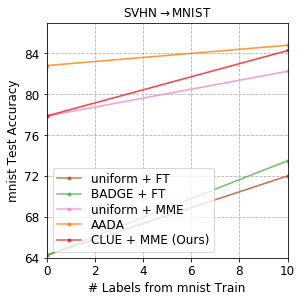

In [22]:
runs=[3,3,3,3,3]
custom_keys = ['uniform + FT', 'BADGE + FT', 'uniform + MME', 'AADA', 'CLUE + MME (Ours)']
custom_title=r'SVHN$\rightarrow$MNIST'
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
lines = utils.plot_perf_curve(axs, target_accs, 'LeNet', source, target, 10, 1, 2, custom_keys, \
                              custom_title, lower_bound=64, upper_bound=87)
plt.legend(lines, custom_keys, labelspacing=0.2)
plt.tight_layout(pad=3)

### Reproduction of Fig. 5 in the paper

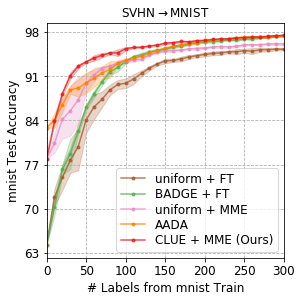

In [23]:
ID='svhn2mnist'
runs = 3
cnn='LeNet'
num_rounds=30
total_budget=300

experiments = ['source_uniform_ft', 'source_BADGE_ft', 'source_uniform_mme', 'source_AADA_dann', 'source_CLUE_mme']
target_accs_repro = {}
for experiment_id in experiments:
    exp_name = '{}_{}_{}runs_{}rounds_{}budget'.format(ID, experiment_id, runs, num_rounds, total_budget)
    results_fname = os.path.join('results', 'perf_{}.json'.format(exp_name))
    target_accs_repro[experiment_id] = json.load(open(results_fname, 'rb'))

custom_title=r'SVHN$\rightarrow$MNIST'
custom_keys = ['uniform + FT', 'BADGE + FT', 'uniform + MME', 'AADA', 'CLUE + MME (Ours)']
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
lines = utils.plot_perf_curve(axs, target_accs_repro, 'LeNet', source, target, total_budget, num_rounds, \
                              num_rounds, custom_keys, custom_title)

plt.legend(lines, custom_keys, labelspacing=0.2)
plt.tight_layout(pad=3)